In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pymc as pm
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

outdir = op.join('..', 'data')

Here is our observation model, this time un-tethered to redshift measurements:

In [3]:
dmax = 1.0

def make_model(Al, Ar, fl=1.0, fr=1.0):
    rho = np.sqrt(0.5*(Al*Al + Ar*Ar))
    with pm.Model() as model:
        x = pm.Uniform('x', lower=-1, upper=1)
        V = pm.Uniform('V', lower=0, upper=dmax*dmax*dmax)
        d = pm.Deterministic('d', V**(1/3))

        _ = pm.Normal('Ar', mu=pt.square(1+x)/d, sigma=1, observed=Ar)
        _ = pm.Normal('Al', mu=pt.square(1-x)/d, sigma=1, observed=Al)

    return model

def draw_Al_Ar(x, d):
    Ar = np.random.normal(loc=np.square(1+x)/d, scale=1)
    Al = np.random.normal(loc=np.square(1-x)/d, scale=1)

    return (Al, Ar)

def draw_observation(snr=None):
    x = np.random.uniform(low=-1, high=1)

    if snr is None:
        V = np.random.uniform(low=0, high=dmax*dmax*dmax)
        d = np.cbrt(V)
    else:
        Al1 = np.square(1-x)
        Ar1 = np.square(1+x)

        rho1 = np.sqrt(0.5*(Al1*Al1 + Ar1*Ar1))
        d = rho1/snr

    Al_obs, Ar_obs = draw_Al_Ar(x, d)
    
    return (x, d, Ar_obs, Al_obs)

In [10]:
# Like GW170817
x = -0.99
d = np.square(1-x)/30

print(f'x = {x}, d = {d}')

Al, Ar = draw_Al_Ar(x, d)
model = make_model(Al, Ar)
with model:
    trace = pm.sample(tune=2000, draws=2000, target_accept=0.98)

x = -0.99, d = 0.13200333333333333


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, V]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [12]:
az.ess(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.084e+03
    V        float64 1.142e+03
    d        float64 1.142e+03

array([[<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>],
       [<AxesSubplot: title={'center': 'V'}>,
        <AxesSubplot: title={'center': 'V'}>],
       [<AxesSubplot: title={'center': 'd'}>,
        <AxesSubplot: title={'center': 'd'}>]], dtype=object)

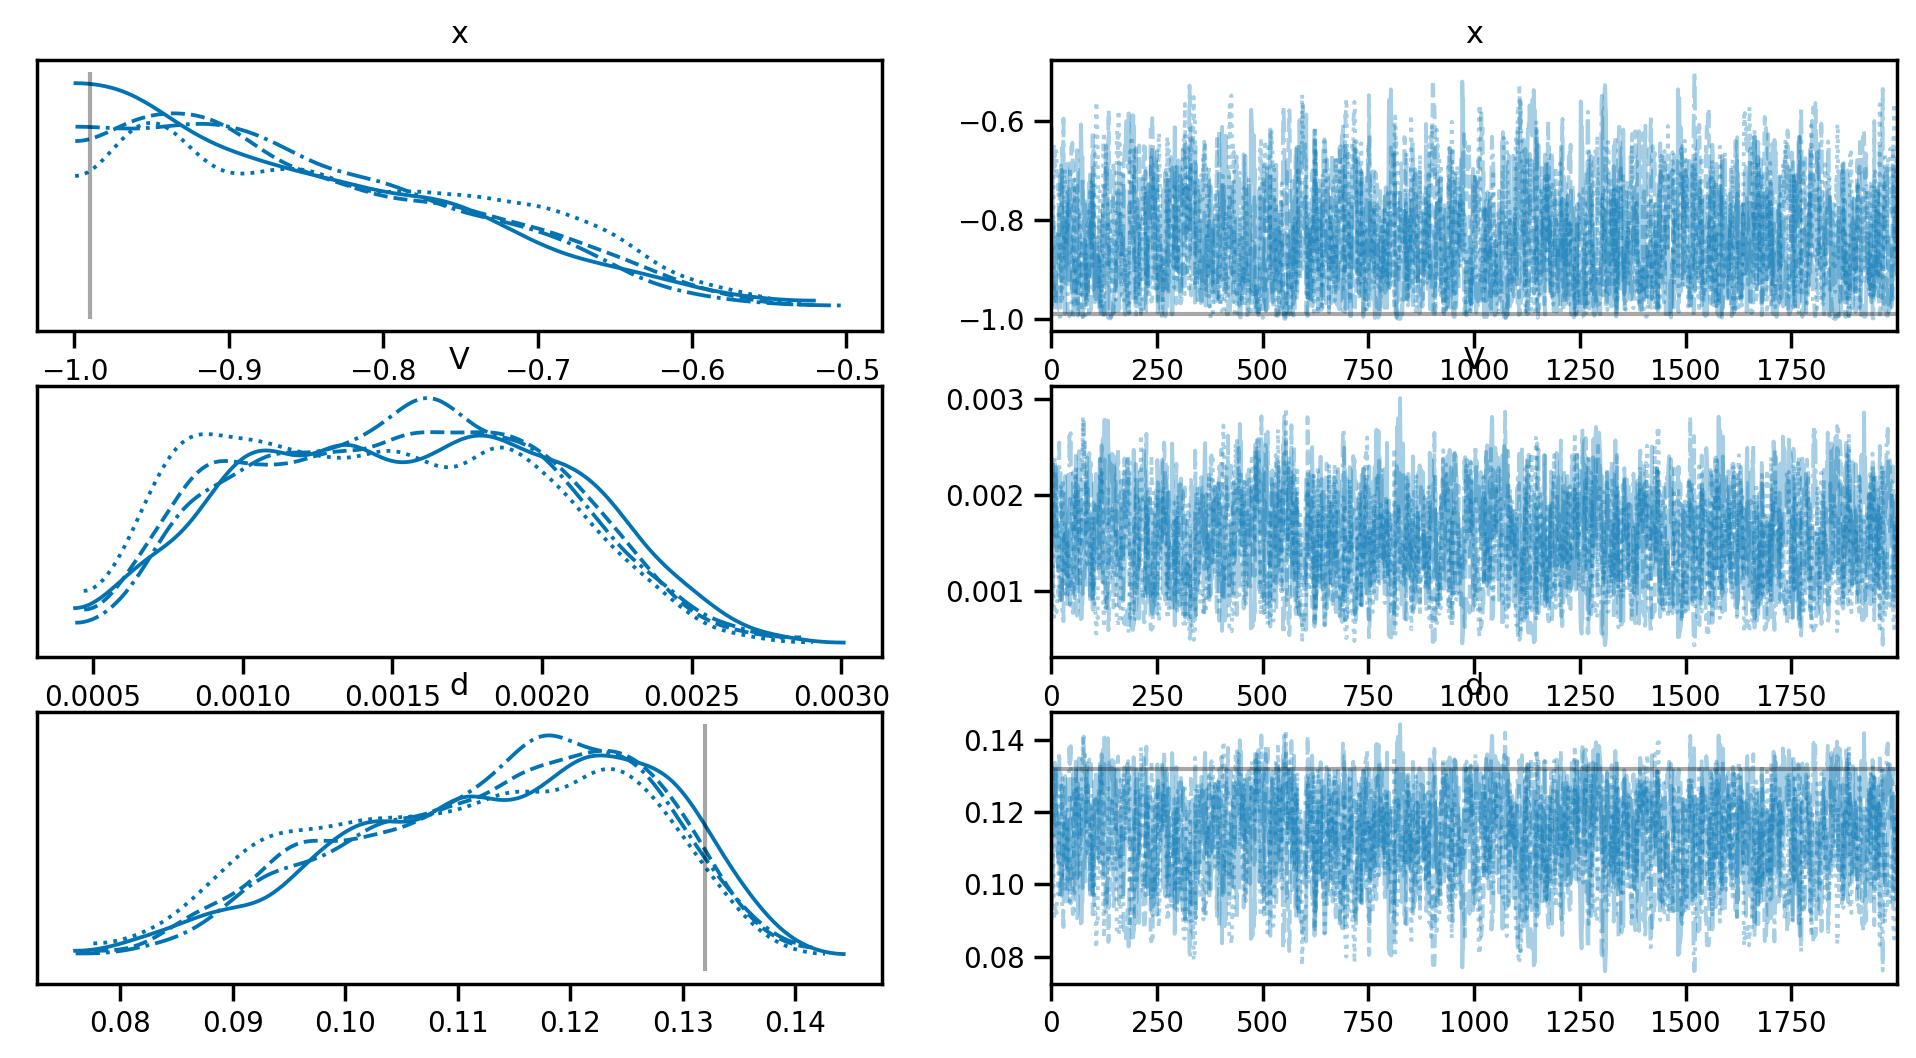

In [11]:
az.plot_trace(trace, lines=[('x', {}, x), ('d', {}, d)])

(-1.0, -0.429387411882977)

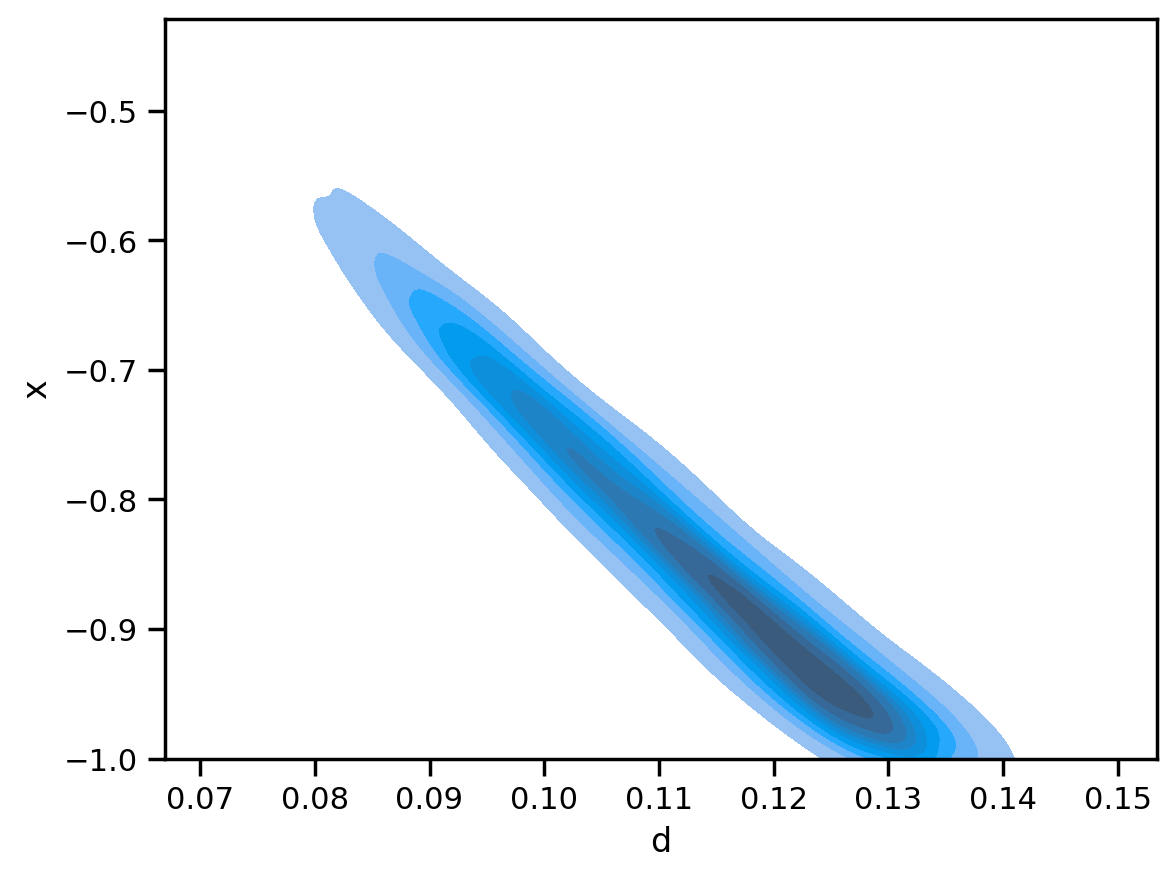

In [14]:
sns.kdeplot(data=az.extract(trace.posterior), x='d', y='x', fill=True)
plt.ylim(bottom=-1)

In [15]:
az.to_netcdf(trace, op.join(outdir, 'GW170817-like-chain.nc'))

'../data/GW170817-like-chain.nc'

Fractional uncertainty on $d$:

In [16]:
d = trace.posterior.d
d.std() / d.mean()

<xarray.DataArray 'd' ()>
array(0.11878271)

What about the maximum $x$?

In [17]:
trace.posterior.x.quantile(0.84)

<xarray.DataArray 'x' ()>
array(-0.72173462)
Coordinates:
    quantile  float64 0.84